# Assessing suppression strategies against epidemic outbreak

Author: Daniele Proverbio, Francoise Kemp  
        LCSB, University of Luxembourg       
        01/04/2020
        
Analysis for manuscript: Proverbio D, Kemp F, Magni S, Husch A, Aalto A, Mombaerts L, Skupin A, Goncalves J,  Ameijeiras-Alonso J, Ley C, "Dynamical SPQEIR model assesses the effectiveness of non-pharmaceutical interventions against COVID-19 epidemic outbreaks", 2020

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd 

from scipy import stats 
from scipy.optimize import curve_fit

In [3]:
# First, we integrate the model with Euler method (faster for repeated loop cycles)
# We initially verified that its dt is sufficient to get sound and correct results wrt odeint method
# odeint will be used for fitting data

#NB: since the delay from initializing measures is fixed (100 simulation steps when dt=0.1, if I want to change dt, I also need to change such delay, or time scales are not respected anymore!)

def base_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    
    S, E, I, R= [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (beta*S[-1]*I[-1])*dt
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T


def delay_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma, rho1, tau = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        if len(E)<tau:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt    
        else:
            next_S = S[-1] - (rho1*beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (rho1*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T



def seir_model_with_soc_dist(init_vals, params, t):
    S_0, E_0, I_0, R_0 = init_vals
    S, E, I, R = [S_0], [E_0], [I_0], [R_0]
    alpha, beta, gamma, rho1 = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        if len(E)<10/dt:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt    
        else:
            next_S = S[-1] - (rho1*beta*S[-1]*I[-1])*dt
            next_E = E[-1] + (rho1*beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
    return np.stack([S, E, I, R]).T


def identify_and_remove_asymptomatic_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0, P_0 = init_vals
    Q_0 = 0
    S, E, I, R, P, Q = [S_0], [E_0], [I_0], [R_0], [P_0], [Q_0]
    alpha, beta, gamma, mu, rho, x, y = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (rho*beta*S[-1]*I[-1] + mu*S[-1])*dt
        
        if len(E)<10/dt:
            next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_Q = Q[-1]
        else: 
            next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1] - y*x*0.33*E[-1])*dt  #3 days to get reliable results from PCR
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_Q = Q[-1] + (y*x*0.33*E[-1])*dt
                           
        next_R = R[-1] + (gamma*I[-1])*dt
        next_P = P[-1] + (mu*S[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
    return np.stack([S, E, I, R, P]).T

def identify_and_remove_infectious_seir_model(init_vals, params, t):
    S_0, E_0, I_0, R_0, P_0 = init_vals
    Q_0 = 0
    S, E, I, R, P, Q = [S_0], [E_0], [I_0], [R_0], [P_0], [Q_0]
    alpha, beta, gamma, mu, rho, eta = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        next_S = S[-1] - (rho*beta*S[-1]*I[-1] + mu*S[-1])*dt
        
        if len(E)<10/dt:
            next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_Q = Q[-1]
        else: 
            next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1])*dt  
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1]  - eta*I[-1])*dt # Immediate removal
            next_Q = Q[-1] + (eta*E[-1])*dt
                           
        next_R = R[-1] + (gamma*I[-1])*dt
        next_P = P[-1] + (mu*S[-1])*dt
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
    return np.stack([S, E, I, R, P]).T

def protection_seir_model(init_vals, params, t):     #protection
    S_0, E_0, I_0, R_0 = init_vals
    P_0 = 0
    S, E, I, R, P = [S_0], [E_0], [I_0], [R_0], [P_0]
    alpha, beta, gamma, mu = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        if len(E)<10/dt:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt
            next_P = P[-1]
        else:
            next_S = S[-1] - (beta*S[-1]*I[-1] + mu*S[-1])*dt
            next_P = P[-1] + (mu*S[-1])*dt
            
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
    return np.stack([S, E, I, R, P]).T


def hard_lockdown_seir_model(init_vals, params, t):     # sudden decrease of susceptible fraction
    S_0, E_0, I_0, R_0 = init_vals
    P_0 = 0
    S, E, I, R, P = [S_0], [E_0], [I_0], [R_0], [P_0]
    alpha, beta, gamma, mu = params
    dt = t[1] - t[0]
    for _ in t[1:]:
        if len(E)<10/dt:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt
            next_P = P[-1]
        if len(E)>=100 and len(E)<140:                  # four days 
            next_S = S[-1] - (beta*S[-1]*I[-1] + mu*S[-1])*dt
            next_P = P[-1] + (mu*S[-1])*dt
        if len(E)>=140:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt
            next_P = P[-1]
            
        next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
        next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
        next_R = R[-1] + (gamma*I[-1])*dt        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
    return np.stack([S, E, I, R, P]).T


## Active latents' removal

In [6]:
# Define parameters
t_max = 1000 #to span time_to_zero better
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2     # incubation period 5 days
beta = 0.85     # average contact rate [beta = R0*gamma; R0 = 2.5 (Hellewell, 2020)]
gamma = 0.34    # mean infectious period = 2.9 (Kucharski,2020)
rho = 1         # social distancing (to control contact rate )    #0.56 to get R_0=2.5, as many predictions do
mu = 0.0        # removal rate
ics = np.linspace(0, 1, 100)    #percentage of asymptomatic correctly identified and removed (detection accuracy)
ypsilon = np.linspace(0, 1, 100) #sensitivity of the tests to get asymptomatic (testing accuracy)

In [48]:
# considering chi
# peak maximum

maximi=np.zeros([100,100])
maximus=np.zeros(100)
maximus_total=np.zeros(100)
maximum_indices = []

starting = 600

zero_infectious_position = np.zeros(100)

for k in range(len(ics)):
    params_identify_exposed = alpha, beta, gamma, mu, rho, ics[k], 1
    results_identify_exposed = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed, t)
    maximus[k]=max(results_identify_exposed.T[2])
    maximus_total[k]=max(results_identify_exposed.T[2]+results_identify_exposed.T[1])
    
    test = results_identify_exposed.T[2,starting:]
    
    for i in range(len(test)):
        if test[i]<=0.00001 and zero_infectious_position[k] ==0:
            zero_infectious_position[k] = i + starting

In [49]:
# considering test sensitivity as standalone, then the rest

for n in range(len(ics)):
    for m in range(len(ypsilon)):
        params_identify_exposed = alpha, beta, gamma, mu, rho, ics[n], ypsilon[m]
        
    
        results_identify_exposed = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed, t)
        #maximus.append(max(results_identify_exposed.T[2]))
        maximi[n,m]=max(results_identify_exposed.T[2])
        #maximum_indices.append(np.where(results_identify_exposed.T[2]==max(results_identify_exposed.T[2])))

### Peak plots

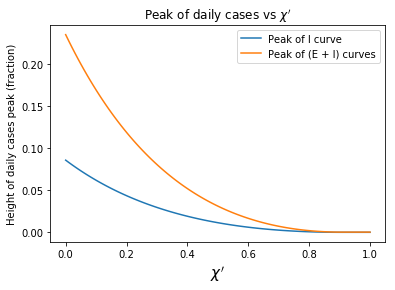

In [50]:
# considering chi (plot)

fig_chi = plt.figure()

plot(ics,maximus, label="Peak of I curve")
plot(ics,maximus_total, label="Peak of (E + I) curves")

plt.title("Peak of daily cases vs $\\chi'$")
xlabel("$\\chi'$",fontsize=15)
ylabel("Height of daily cases peak (fraction)")
plt.legend()

fig_chi.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/chi.pdf",bbox_inches = "tight",transparent=True)

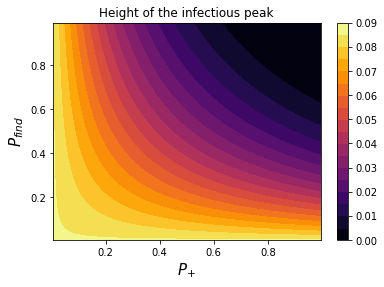

In [51]:
# considering test sensitivity as standalone, then the rest

import matplotlib.pyplot as pylt
import matplotlib.colors as mcolors

fig, ax = plt.subplots()

plt.contourf(maximi,20, cmap='inferno',extent=[0,1,0,1],origin="lower")   #other colormap:viridis
plt.colorbar()


plt.xlabel('$P_{+}$',fontsize=15) #corresponds to ypsilon
plt.ylabel('$P_{find}$',fontsize=15) #corresponds to ics
#plt.xlabel("Test accuracy")    
#plt.ylabel("Detection accuracy")    
plt.title("Height of the infectious peak")
#fig.patch.set_facecolor('xkcd:silver')

plt.show()

fig.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/chi_tests.png",bbox_inches = "tight",transparent=True)

In [52]:
# Precise control on plots for showing

params_identify_exposed_1 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[10]
params_identify_exposed_2 = alpha, beta, gamma, mu, rho, ics[82], ypsilon[20]
params_identify_exposed_3 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[30]
params_identify_exposed_4 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[40]
params_identify_exposed_5 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[50]
params_identify_exposed_6 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[60]
params_identify_exposed_7 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[70]
params_identify_exposed_8 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[80]
params_identify_exposed_9 = alpha, beta, gamma, mu, rho, ics[81], ypsilon[90]


results_identify_exposed_1 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_1, t)
results_identify_exposed_2 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_2, t)
results_identify_exposed_3 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_3, t)
results_identify_exposed_4 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_4, t)
results_identify_exposed_5 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_5, t)
results_identify_exposed_6 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_6, t)
results_identify_exposed_7 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_7, t)
results_identify_exposed_8 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_8, t)
results_identify_exposed_9 = identify_and_remove_asymptomatic_seir_model(init_vals[:5], params_identify_exposed_9, t)

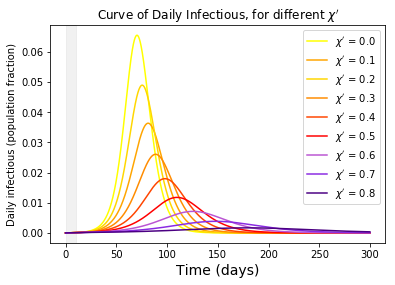

In [56]:
a, ax = plt.subplots(nrows=1, ncols=1)

plt.plot(t[:3000],results_identify_exposed_1.T[2,:3000],"yellow",label="$\\chi'$ = 0.0")
plt.plot(t[:3000],results_identify_exposed_3.T[2,:3000],"orange",label="$\\chi'$ = 0.1")
plt.plot(t[:3000],results_identify_exposed_2.T[2,:3000],"gold",label="$\\chi'$ = 0.2")
plt.plot(t[:3000],results_identify_exposed_4.T[2,:3000],"darkorange",label="$\\chi'$ = 0.3")
plt.plot(t[:3000],results_identify_exposed_5.T[2,:3000],"orangered",label="$\\chi'$ = 0.4")
plt.plot(t[:3000],results_identify_exposed_6.T[2,:3000],"red",label="$\\chi'$ = 0.5")
plt.plot(t[:3000],results_identify_exposed_7.T[2,:3000],"mediumorchid",label="$\\chi'$ = 0.6")
plt.plot(t[:3000],results_identify_exposed_8.T[2,:3000],"blueviolet",label="$\\chi'$ = 0.7")
plt.plot(t[:3000],results_identify_exposed_9.T[2,:3000],"indigo",label="$\\chi'$ = 0.8")
#follow inferno colormap

plt.title("Curve of Daily Infectious, for different $\\chi'$")
xlabel("Time (days)", fontsize=14)
plt.legend()
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Daily infectious (population fraction)")

a.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/chi_curves.pdf",bbox_inches = "tight",transparent=True)

### Time-to-zero plot

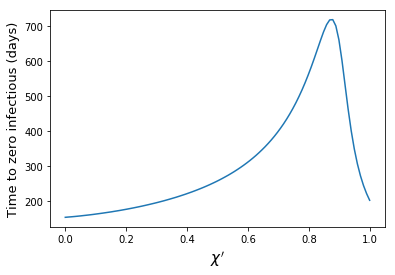

In [54]:
# considering chi (plot)

#data_zero_infectious = [1428,1555,1720,1954,2297,2838]


fig_time = plt.figure()
plot(ics,zero_infectious_position*dt)

xlabel("$\\chi'$",fontsize=15)
ylabel("Time to zero infectious (days)",fontsize=13)

fig_time.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/chi_tests.pdf",bbox_inches = "tight",transparent=True)

# Infectious removal

In [4]:
# Define parameters
t_max = 1000 #to span time_to_zero better
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2     # incubation period 5 days
beta = 0.85     # average contact rate [beta = R0*gamma; R0 = 2.5 (Hellewell, 2020)]
gamma = 0.34    # mean infectious period = 2.9 (Kucharski,2020)
rho = 1         # social distancing (to control contact rate )    #0.56 to get R_0=2.5, as many predictions do
mu = 0.0        # removal rate
eta = np.linspace(0, 1, 100)    #percentage of infectious correctly identified and removed (detection accuracy)
#ypsilon = np.linspace(0, 1, 100) #sensitivity of the tests to get symptomatics (testing accuracy)

In [5]:
# considering eta
# peak maximum

maximi=np.zeros([100,100])
maximus=np.zeros(100)
maximus_total=np.zeros(100)
maximum_indices = []

starting = 600

zero_infectious_position = np.zeros(100)

for k in range(len(eta)):
    params_identify_inf = alpha, beta, gamma, mu, rho, eta[k]
    results_identify_inf = identify_and_remove_infectious_seir_model(init_vals[:5], params_identify_inf, t)
    maximus[k]=max(results_identify_inf.T[2])
    maximus_total[k]=max(results_identify_inf.T[2]+results_identify_inf.T[1])
    
    test = results_identify_inf.T[2,starting:]
    
    for i in range(len(test)):
        if test[i]<=0.00001 and zero_infectious_position[k] ==0:
            zero_infectious_position[k] = i + starting

### Peak plots

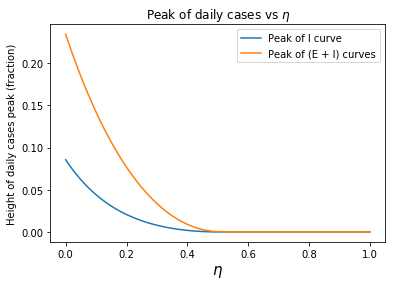

In [7]:
# considering chi (plot)

fig_eta = plt.figure()

plot(eta,maximus, label="Peak of I curve")
plot(eta,maximus_total, label="Peak of (E + I) curves")

plt.title("Peak of daily cases vs $\\eta$")
xlabel("$\\eta$",fontsize=15)
ylabel("Height of daily cases peak (fraction)")
plt.legend()

fig_eta.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/eta.pdf",bbox_inches = "tight",transparent=True)

In [8]:
# Precise control on plots for showing

params_identify_inf_1 = alpha, beta, gamma, mu, rho, eta[1]
params_identify_inf_2 = alpha, beta, gamma, mu, rho, eta[9]
params_identify_inf_3 = alpha, beta, gamma, mu, rho, eta[18]
params_identify_inf_4 = alpha, beta, gamma, mu, rho, eta[26]
params_identify_inf_5 = alpha, beta, gamma, mu, rho, eta[34]
params_identify_inf_6 = alpha, beta, gamma, mu, rho, eta[42]
params_identify_inf_7 = alpha, beta, gamma, mu, rho, eta[50]
params_identify_inf_8 = alpha, beta, gamma, mu, rho, eta[58]
params_identify_inf_9 = alpha, beta, gamma, mu, rho, eta[64]


results_identify_inf_1 = identify_and_remove_infectious_seir_model(init_vals[:5], params_identify_inf_1, t)
results_identify_inf_2 = identify_and_remove_infectious_seir_model(init_vals[:5], params_identify_inf_2, t)
results_identify_inf_3 = identify_and_remove_infectious_seir_model(init_vals[:5], params_identify_inf_3, t)
results_identify_inf_4 = identify_and_remove_infectious_seir_model(init_vals[:5], params_identify_inf_4, t)
results_identify_inf_5 = identify_and_remove_infectious_seir_model(init_vals[:5], params_identify_inf_5, t)
results_identify_inf_6 = identify_and_remove_infectious_seir_model(init_vals[:5], params_identify_inf_6, t)
results_identify_inf_7 = identify_and_remove_infectious_seir_model(init_vals[:5], params_identify_inf_7, t)
results_identify_inf_8 = identify_and_remove_infectious_seir_model(init_vals[:5], params_identify_inf_8, t)
results_identify_inf_9 = identify_and_remove_infectious_seir_model(init_vals[:5], params_identify_inf_9, t)

In [9]:
eta[18]

0.18181818181818182

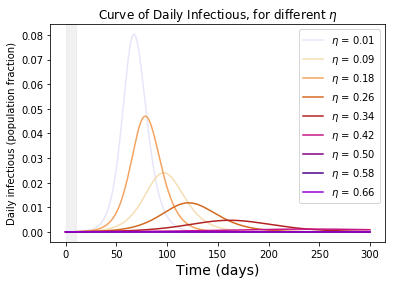

In [14]:
a, ax = plt.subplots(nrows=1, ncols=1)

plt.plot(t[:3000],results_identify_inf_1.T[2,:3000],"lavender",label="$\\eta$ = 0.01")
plt.plot(t[:3000],results_identify_inf_3.T[2,:3000],"wheat",label="$\\eta$ = 0.09")
plt.plot(t[:3000],results_identify_inf_2.T[2,:3000],"sandybrown",label="$\\eta$ = 0.18")
plt.plot(t[:3000],results_identify_inf_4.T[2,:3000],"chocolate",label="$\\eta$ = 0.26")
plt.plot(t[:3000],results_identify_inf_5.T[2,:3000],"firebrick",label="$\\eta$ = 0.34")
plt.plot(t[:3000],results_identify_inf_6.T[2,:3000],"mediumvioletred",label="$\\eta$ = 0.42")
plt.plot(t[:3000],results_identify_inf_7.T[2,:3000],"purple",label="$\\eta$ = 0.50")
plt.plot(t[:3000],results_identify_inf_8.T[2,:3000],"indigo",label="$\\eta$ = 0.58")
plt.plot(t[:3000],results_identify_inf_9.T[2,:3000],"darkviolet",label="$\\eta$ = 0.66")
#follow twilight colormap

plt.title("Curve of Daily Infectious, for different $\\eta$")
xlabel("Time (days)", fontsize=14)
plt.legend()
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Daily infectious (population fraction)")

a.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/eta_curves.pdf",bbox_inches = "tight",transparent=True)

### Time to zero plot

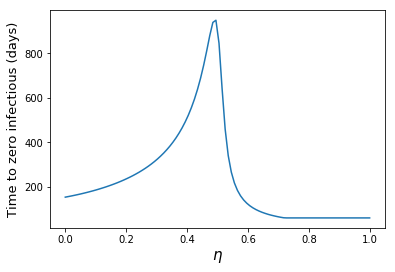

In [15]:
# considering chi (plot)

#data_zero_infectious = [1428,1555,1720,1954,2297,2838]


fig_time = plt.figure()
plot(eta,zero_infectious_position*dt)

xlabel("$\\eta$",fontsize=15)
ylabel("Time to zero infectious (days)",fontsize=13)

fig_time.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/eta_tests.pdf",bbox_inches = "tight",transparent=True)

# Only social distancing

In [59]:
# Define parameters
t_max = 1000
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2    # incubation period 5 days
beta = 0.85    # average contact rate [beta = R0*gamma; R0 = 3.5 (Hellewell, 2020); R0 = 3 from GEI]
gamma = 0.34   # mean infectious period = 3 following German Epidemiology Institute (GEI) [or = 2 (Peng, 2020) in Wuhan]
rho = np.linspace(0, 1, 1000)   # social distancing (to control contact rate )
rho1 = 0.4
mu = 0.0     # removal rate

In [60]:
# considering rho
# peak maximum

maximi_sd=np.zeros([1000,1000])
maximus_sd=np.zeros(1000)
maximus_total_sd=np.zeros(1000)
maximum_indices_sd = []

starting = 600

zero_infectious_position_sd = np.zeros(1000)

for k in range(len(rho)):
    params_soc_dist = alpha, beta, gamma, rho[k]     
    results_soc_dist = seir_model_with_soc_dist(init_vals[:4], params_soc_dist, t)
    maximus_sd[k]=max(results_soc_dist.T[2])
    maximus_total_sd[k]=max(results_soc_dist.T[2]+results_soc_dist.T[1])
    
    test_sd = results_soc_dist.T[2,starting:]
    
    for i in range(len(test_sd)):
        if test_sd[i]<=0.00005 and zero_infectious_position_sd[k] ==0:
            zero_infectious_position_sd[k] = i + starting

In [61]:
# Just a sample

params_soc_dist_1 = alpha, beta, gamma, rho[100]
params_soc_dist_2 = alpha, beta, gamma, rho[200]
params_soc_dist_3 = alpha, beta, gamma, rho[300]
params_soc_dist_4 = alpha, beta, gamma, rho[400]
params_soc_dist_5 = alpha, beta, gamma, rho[500]
params_soc_dist_6 = alpha, beta, gamma, rho[600]
params_soc_dist_7 = alpha, beta, gamma, rho[700]
params_soc_dist_8 = alpha, beta, gamma, rho[800]
params_soc_dist_9 = alpha, beta, gamma, rho[900]

params_soc_dist_10 = alpha, beta, gamma, 0.4


results_soc_dist_1 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_1, t)
results_soc_dist_2 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_2, t)
results_soc_dist_3 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_3, t)
results_soc_dist_4 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_4, t)
results_soc_dist_5 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_5, t)
results_soc_dist_6 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_6, t)
results_soc_dist_7 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_7, t)
results_soc_dist_8 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_8, t)
results_soc_dist_9 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_9, t)

results_soc_dist_10 = seir_model_with_soc_dist(init_vals[:4], params_soc_dist_10, t)

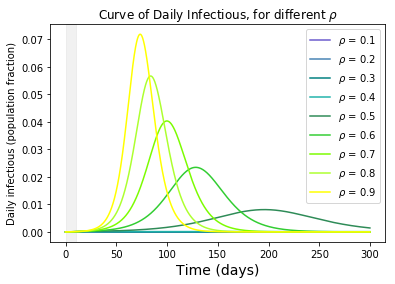

In [63]:
b, ax = plt.subplots(nrows=1, ncols=1)

stop_plot1 = 3000

plt.plot(t[:stop_plot1],results_soc_dist_1.T[2,:stop_plot1],"slateblue",label="$\\rho$ = 0.1")
plt.plot(t[:stop_plot1],results_soc_dist_3.T[2,:stop_plot1],"steelblue",label="$\\rho$ = 0.2")
plt.plot(t[:stop_plot1],results_soc_dist_2.T[2,:stop_plot1],"teal",label="$\\rho$ = 0.3")
plt.plot(t[:stop_plot1],results_soc_dist_4.T[2,:stop_plot1],"lightseagreen",label="$\\rho$ = 0.4")
plt.plot(t[:stop_plot1],results_soc_dist_5.T[2,:stop_plot1],"seagreen",label="$\\rho$ = 0.5")
plt.plot(t[:stop_plot1],results_soc_dist_6.T[2,:stop_plot1],"limegreen",label="$\\rho$ = 0.6")
plt.plot(t[:stop_plot1],results_soc_dist_7.T[2,:stop_plot1],"lawngreen",label="$\\rho$ = 0.7")
plt.plot(t[:stop_plot1],results_soc_dist_8.T[2,:stop_plot1],"greenyellow",label="$\\rho$ = 0.8")
plt.plot(t[:stop_plot1],results_soc_dist_9.T[2,:stop_plot1],"yellow",label="$\\rho$ = 0.9")
#follow viridis colormap

plt.title("Curve of Daily Infectious, for different $\\rho$")
xlabel("Time (days)", fontsize=14)
plt.legend()

ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Daily infectious (population fraction)")

b.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/rho_curves.pdf",bbox_inches = "tight",transparent=True)

In [20]:
np.savetxt('sims.txt', results_soc_dist_2.T[2,:stop_plot1]*600000)

### Peak Plots

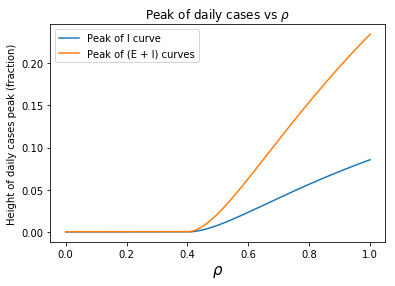

In [64]:
# considering rho (plot)

fig_rho = plt.figure()

plot(rho,maximus_sd, label="Peak of I curve")
plot(rho,maximus_total_sd, label="Peak of (E + I) curves")

plt.title("Peak of daily cases vs $\\rho$")
xlabel("$\\rho$",fontsize=15)
ylabel("Height of daily cases peak (fraction)")
plt.legend()

fig_rho.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/rho.pdf",bbox_inches = "tight",transparent=True)

### Time-to-zero plot

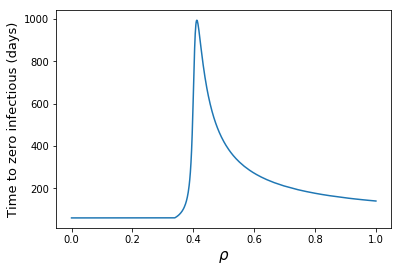

In [65]:
fig_time = plt.figure()
plot(rho,zero_infectious_position_sd*dt)

xlabel("$\\rho$",fontsize=15)
ylabel("Time to zero infectious (days)",fontsize=13)

fig_time.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/rho_tests.pdf",bbox_inches = "tight",transparent=True)

# Only Active protection

In [66]:
# Define parameters
t_max = 1000
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2    # incubation period 5 days
beta = 0.85    # average contact rate 
gamma = 0.34   # mean infectious period = 3 following German Epidemiology Institute (GEI) [or = 2 (Peng, 2020) in Wuhan]
rho = 1   # social distancing (to control contact rate )
mu = np.linspace(0, 0.2, 100)     # removal rate

In [67]:
# considering mu
# peak maximum

maximi_pr=np.zeros([100,100])
maximus_pr=np.zeros(100)
maximus_total_pr=np.zeros(100)
maximum_indices_pr = []

starting = 600

zero_infectious_position_pr = np.zeros(100)

for k in range(len(mu)):
    params_protection = alpha, beta, gamma, mu[k]     
    results_protection = protection_seir_model(init_vals[:4], params_protection, t)
    maximus_pr[k]=max(results_protection.T[2])
    maximus_total_pr[k]=max(results_protection.T[2]+results_protection.T[1])
    
    test_pr = results_protection.T[2,starting:]
    
    for i in range(len(test_sd)):
        if test_pr[i]<=0.0000001 and zero_infectious_position_pr[k] ==0:
            zero_infectious_position_pr[k] = i + starting

### Peak plots

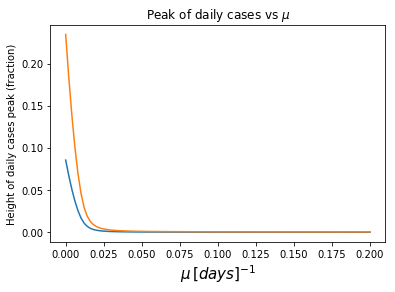

In [68]:
# considering chi (plot)

fig_mu = plt.figure()

plot(mu,maximus_pr, label="Peak of I curve")
plot(mu,maximus_total_pr, label="Peak of (E + I) curves")

plt.title("Peak of daily cases vs $\\mu$")
xlabel("$\\mu \, [days]^{-1}$",fontsize=15)
ylabel("Height of daily cases peak (fraction)")
#plt.legend()

fig_mu.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/mu.pdf",bbox_inches = "tight",transparent=True)

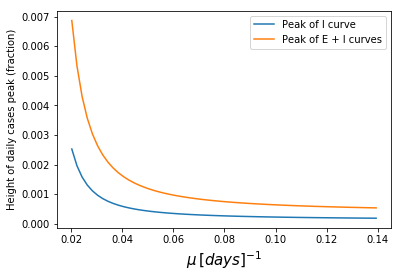

In [69]:
# considering chi (plot)

fig_mu = plt.figure()

plot(mu[10:70],maximus_pr[10:70], label="Peak of I curve")
plot(mu[10:70],maximus_total_pr[10:70], label="Peak of E + I curves")

#plt.title("Peak of daily cases vs $\\mu$")
xlabel("$\\mu  \, [days]^{-1}$",fontsize=15)
ylabel("Height of daily cases peak (fraction)")
plt.legend()

fig_mu.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/mu1.pdf",bbox_inches = "tight",transparent=True)

In [70]:
# Just a sample

params_protection_1 = alpha, beta, gamma, mu[10] 
params_protection_2 = alpha, beta, gamma, mu[20] 
params_protection_3 = alpha, beta, gamma, mu[30] 
params_protection_4 = alpha, beta, gamma, mu[40] 
params_protection_5 = alpha, beta, gamma, mu[50] 
params_protection_6 = alpha, beta, gamma, mu[60] 
params_protection_7 = alpha, beta, gamma, mu[70] 
params_protection_8 = alpha, beta, gamma, mu[80] 
params_protection_9 = alpha, beta, gamma, mu[90] 

params_protection_15 = alpha, beta, gamma, mu[1] 
params_protection_13 = alpha, beta, gamma, mu[2] 
params_protection_10 = alpha, beta, gamma, mu[3] 
params_protection_11 = alpha, beta, gamma, mu[4] 
params_protection_12 = alpha, beta, gamma, mu[5] 
params_protection_14 = alpha, beta, gamma, mu[6] 
params_protection_16 = alpha, beta, gamma, mu[0] 


results_protection_1 = protection_seir_model(init_vals[:4], params_protection_1, t)
results_protection_2 = protection_seir_model(init_vals[:4], params_protection_2, t)
results_protection_3 = protection_seir_model(init_vals[:4], params_protection_3, t)
results_protection_4 = protection_seir_model(init_vals[:4], params_protection_4, t)
results_protection_5 = protection_seir_model(init_vals[:4], params_protection_5, t)
results_protection_6 = protection_seir_model(init_vals[:4], params_protection_6, t)
results_protection_7 = protection_seir_model(init_vals[:4], params_protection_7, t)
results_protection_8 = protection_seir_model(init_vals[:4], params_protection_8, t)
results_protection_9 = protection_seir_model(init_vals[:4], params_protection_9, t)

results_protection_10 = protection_seir_model(init_vals[:4], params_protection_10, t)
results_protection_11 = protection_seir_model(init_vals[:4], params_protection_11, t)
results_protection_12 = protection_seir_model(init_vals[:4], params_protection_12, t)
results_protection_13 = protection_seir_model(init_vals[:4], params_protection_13, t)
results_protection_14 = protection_seir_model(init_vals[:4], params_protection_14, t)
results_protection_15 = protection_seir_model(init_vals[:4], params_protection_15, t)
results_protection_16 = protection_seir_model(init_vals[:4], params_protection_16, t)

In [71]:
mu[80]

0.1616161616161616

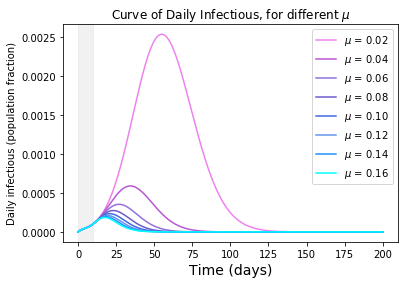

In [72]:
c, ax = plt.subplots(nrows=1, ncols=1)

stop_plot = 2000

#correct legend!
#plt.plot(t[:stop_plot],results_protection_14.T[2,:stop_plot],"plum",label="$\\mu$ = 0.01")
plt.plot(t[:stop_plot],results_protection_1.T[2,:stop_plot],"violet",label="$\\mu$ = 0.02")
plt.plot(t[:stop_plot],results_protection_2.T[2,:stop_plot],"mediumorchid",label="$\\mu$ = 0.04")
plt.plot(t[:stop_plot],results_protection_3.T[2,:stop_plot],"mediumpurple",label="$\\mu$ = 0.06")
plt.plot(t[:stop_plot],results_protection_4.T[2,:stop_plot],"slateblue",label="$\\mu$ = 0.08")
plt.plot(t[:stop_plot],results_protection_5.T[2,:stop_plot],"royalblue",label="$\\mu$ = 0.10")
plt.plot(t[:stop_plot],results_protection_6.T[2,:stop_plot],"cornflowerblue",label="$\\mu$ = 0.12")
plt.plot(t[:stop_plot],results_protection_7.T[2,:stop_plot],"dodgerblue",label="$\\mu$ = 0.14")
plt.plot(t[:stop_plot],results_protection_8.T[2,:stop_plot],"aqua",label="$\\mu$ = 0.16")
#plt.plot(t[:stop_plot],results_protection_9.T[2,:stop_plot],"aqua",label="$\\mu$ = 0.18")
#follow cool colormap

plt.title("Curve of Daily Infectious, for different $\\mu$")
xlabel("Time (days)", fontsize=14)
plt.legend()
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Daily infectious (population fraction)")

c.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/mu_curves.pdf",bbox_inches = "tight",transparent=True)

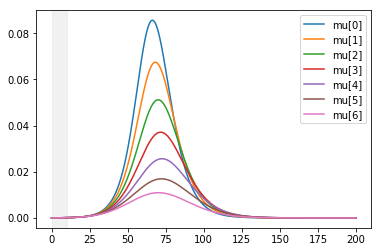

In [30]:
# zooming in
z, ax = plt.subplots(nrows=1, ncols=1)

plt.plot(t[:2000], results_protection_16.T[2,:2000],label="mu[0]")
plt.plot(t[:2000], results_protection_15.T[2,:2000],label="mu[1]")
plt.plot(t[:2000], results_protection_13.T[2,:2000],label="mu[2]")
plt.plot(t[:2000], results_protection_10.T[2,:2000],label="mu[3]")
plt.plot(t[:2000], results_protection_11.T[2,:2000],label="mu[4]")
plt.plot(t[:2000], results_protection_12.T[2,:2000],label="mu[5]")
plt.plot(t[:2000], results_protection_14.T[2,:2000],label="mu[6]")
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

plt.legend()

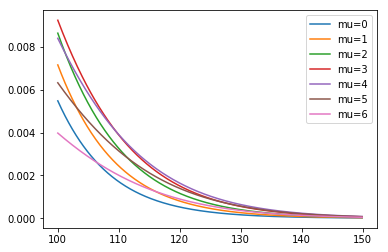

In [31]:
# zooming in the zooming in
plt.plot(t[1000:1500], results_protection_16.T[2,1000:1500],label="mu=0")
plt.plot(t[1000:1500], results_protection_15.T[2,1000:1500],label="mu=1")
plt.plot(t[1000:1500], results_protection_13.T[2,1000:1500],label="mu=2")
plt.plot(t[1000:1500], results_protection_10.T[2,1000:1500],label="mu=3")
plt.plot(t[1000:1500], results_protection_11.T[2,1000:1500],label="mu=4")
plt.plot(t[1000:1500], results_protection_12.T[2,1000:1500],label="mu=5")
plt.plot(t[1000:1500], results_protection_14.T[2,1000:1500],label="mu=6")

plt.legend()

### Time-to-zero plot

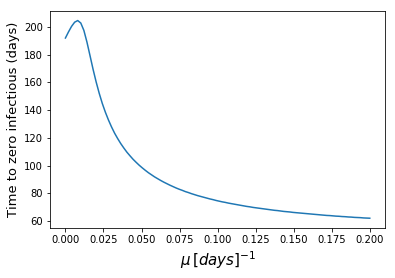

In [73]:
fig_time = plt.figure()
plot(mu,zero_infectious_position_pr*dt)

xlabel("$\\mu  \, [days]^{-1}$",fontsize=15)
ylabel("Time to zero infectious (days)",fontsize=13)

fig_time.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/mu_tests.pdf",bbox_inches = "tight",transparent=True)

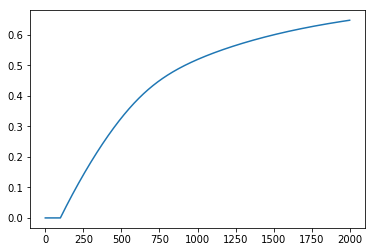

In [74]:
# cumulative protected

mu[4]

plot(results_protection_12.T[4,:2000])

### Effect of hard lockdown

In [75]:
# with high mu, but for short periods, to isolate vast fraction of the population

# Define parameters
t_max = 1000
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2    # incubation period 5 days
beta = 0.85    # average contact rate 
gamma = 0.34   # mean infectious period = 3 following German Epidemiology Institute (GEI) [or = 2 (Peng, 2020) in Wuhan]
rho = 1   # social distancing (to control contact rate )
mu1 = np.linspace(0.1, 1, 100)     # removal rate

In [76]:
# considering mu
# peak maximum

maximi_ld=np.zeros([100,100])
maximus_ld=np.zeros(100)
maximus_total_ld=np.zeros(100)
maximum_indices_ld = []

starting = 600

zero_infectious_position_ld = np.zeros(100)

for k in range(len(mu)):
    params_lockdown = alpha, beta, gamma, mu1[k]     
    results_lockdown = hard_lockdown_seir_model(init_vals[:4], params_lockdown, t)
    maximus_ld[k]=max(results_lockdown.T[2])
    maximus_total_ld[k]=max(results_lockdown.T[2]+results_lockdown.T[1])
    
    test_ld = results_lockdown.T[2,starting:]
    
    for i in range(len(test_sd)):
        if test_ld[i]<=0.0000001 and zero_infectious_position_ld[k] ==0:
            zero_infectious_position_ld[k] = i + starting

In [77]:
# Just a sample

params_lockdown_1 = alpha, beta, gamma, mu1[10] 
params_lockdown_2 = alpha, beta, gamma, mu1[20] 
params_lockdown_3 = alpha, beta, gamma, mu1[30] 
params_lockdown_4 = alpha, beta, gamma, mu1[40] 
params_lockdown_5 = alpha, beta, gamma, mu1[50] 
params_lockdown_6 = alpha, beta, gamma, mu1[60] 
params_lockdown_7 = alpha, beta, gamma, mu1[70] 
params_lockdown_8 = alpha, beta, gamma, mu1[80] 
params_lockdown_9 = alpha, beta, gamma, mu1[90] 


results_lockdown_1 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_1, t)
results_lockdown_2 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_2, t)
results_lockdown_3 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_3, t)
results_lockdown_4 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_4, t)
results_lockdown_5 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_5, t)
results_lockdown_6 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_6, t)
results_lockdown_7 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_7, t)
results_lockdown_8 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_8, t)
results_lockdown_9 = hard_lockdown_seir_model(init_vals[:4], params_lockdown_9, t)

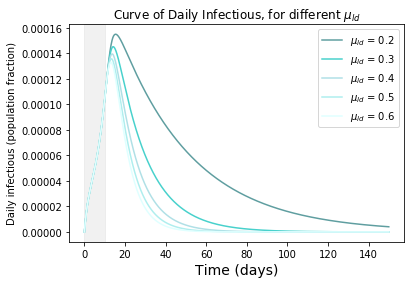

In [78]:
d, ax = plt.subplots(nrows=1, ncols=1)

stop_plot = 1500
 
#plt.plot(t[:stop_plot],results_lockdown_2.T[2,:stop_plot],"teal",label="$\\mu$ = 0.4")   #let's see if inserting or not. It's constant as predicted by the formula...
plt.plot(t[:stop_plot],results_lockdown_2.T[2,:stop_plot],"cadetblue",label="$\\mu_{ld}$ = 0.2")
plt.plot(t[:stop_plot],results_lockdown_3.T[2,:stop_plot],"mediumturquoise",label="$\\mu_{ld}$ = 0.3")
plt.plot(t[:stop_plot],results_lockdown_4.T[2,:stop_plot],"powderblue",label="$\\mu_{ld}$ = 0.4")
plt.plot(t[:stop_plot],results_lockdown_5.T[2,:stop_plot],"paleturquoise",label="$\\mu_{ld}$ = 0.5")
plt.plot(t[:stop_plot],results_lockdown_6.T[2,:stop_plot],"lightcyan",label="$\\mu_{ld}$ = 0.6")
#follow cool colormap

plt.title("Curve of Daily Infectious, for different $\\mu_{ld}$")
xlabel("Time (days)", fontsize=14)
plt.legend()
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Daily infectious (population fraction)")

d.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/assessingSuppressionMeasures/plots_covid/mu_curves1.pdf",bbox_inches = "tight",transparent=True)


Text(0,0.5,'Population fraction (protected)')

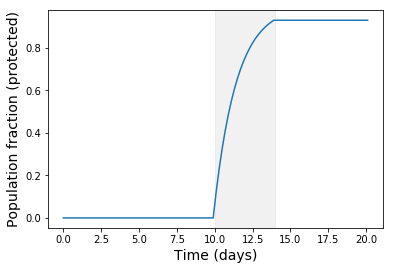

In [79]:
# Plot hard lockdown mu

mock_time = np.linspace(0,20,101)
mu_5 = []
for i in mock_time:
    if i<10:
        mu_5.append(0)
    elif i>= 10 and i <14:
        mu_5.append(0.68)
    else:
        mu_5.append(0)

e, ax = plt.subplots(nrows=1, ncols=1)
stop_plot_hard_ld = len(mock_time)*2
plt.plot(t[:stop_plot_hard_ld],results_lockdown_6.T[4,:stop_plot_hard_ld],label="Total Protected")
ax.axvspan(10, 14, alpha=0.3, color='lightgrey')
xlabel("Time (days)", fontsize=14)
ylabel("Population fraction (protected)", fontsize=14)


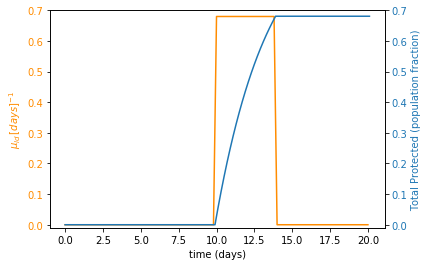

In [80]:
# plot combination

fig_e, ax1 = plt.subplots()

color = "darkorange"
ax1.set_xlabel('time (days)')
ax1.set_ylabel('$\\mu_{ld}  \, [days]^{-1}$', color=color)
ax1.plot(mock_time, mu_5, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ylim(-0.01,0.7)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Total Protected (population fraction)', color=color)  # we already handled the x-label with ax1
ax2.plot(t[:stop_plot_hard_ld], results_lockdown_2.T[4,:stop_plot_hard_ld], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ylim(-0.01,0.7)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


fig_e.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/mu_hard_lockdown.pdf",bbox_inches = "tight",transparent=True)

# Synergies
Let's look at some synergistic approach that does not involve extremes, but yields suppression.    
From the formula in the manuscript, we know how to get R<1 by tuning parameters. Let us simulate a few settings.   

In [4]:
# synergies

def synergies_seir_model(init_vals, params, t):    
    S_0, E_0, I_0, R_0, P_0, Q_0 = init_vals
    S, E, I, R, P, Q = [S_0], [E_0], [I_0], [R_0], [P_0], [Q_0]
    alpha, beta, gamma, mu, mu_ld, rho, chi, eta = params[0:8]
    if len(params)==9:
        tau = params[8]
    else:
        tau = 100
        
    
    dt = t[1] - t[0]
    for _ in t[1:]:
        
        if len(E)<tau:
            next_S = S[-1] - (beta*S[-1]*I[-1])*dt       
            next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_P = P[-1]
            next_Q = Q[-1]
        elif len(E)>=tau and len(E)<tau+40:                  # tau = days from first case to lockdown; +40 = 4 days for measures to take effectiveness, related to Mobility Reports
            next_S = S[-1] - (beta*S[-1]*I[-1] + mu_ld*S[-1])*dt
            next_E = E[-1] + (beta*S[-1]*I[-1] - alpha*E[-1])*dt
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1])*dt
            next_P = P[-1] + (mu_ld*S[-1])*dt
            next_Q = Q[-1]
        elif len(E)>=tau+40: 
            next_S = S[-1] - (rho*beta*S[-1]*I[-1] + mu*S[-1])*dt
            next_E = E[-1] + (rho*beta*S[-1]*I[-1] - alpha*E[-1] - chi*0.33*E[-1])*dt  #3 days to get reliable results from PCR
            next_I = I[-1] + (alpha*E[-1] - gamma*I[-1] - eta*I[-1])*dt
            next_Q = Q[-1] + (chi*0.33*E[-1] + eta*I[-1])*dt
            next_P = P[-1] + (mu*S[-1])*dt
                           
        next_R = R[-1] + (gamma*I[-1])*dt
        
        S.append(next_S)
        E.append(next_E)
        I.append(next_I)
        R.append(next_R)
        P.append(next_P)
        Q.append(next_Q)
    return np.stack([S, E, I, R, P, Q]).T


In [5]:
# Define parameters
t_max = 1000
dt = .1
t = np.linspace(0, t_max, int(t_max/dt) + 1)

N = 10000
init_vals = 1 - 1/N, 1/N, 0, 0, 0 ,0    #working with fractions of population
alpha = 0.2     # incubation period 5 days
beta = 0.85     # average contact rate [beta = R0*gamma; R0 = 2.5 (Hellewell, 2020)]
gamma = 0.34    # mean infectious period = 2.9 (Kucharski,2020)
mu =    [0.0,   0.0,   0.0,   0.,   0.002, 0    ]      # removal rate
mu_ld = [0.12,  0.06,  0.08,  0.,   0.1,   0.3  ]      # removal rate for hard lockdown
rho =   [0.7,   0.65,  0.45,  0.6,  0.7,   1    ]      # social distancing tuning
chi =   [0.12,  0.55,  0.03,  0.2,  0. ,   0.1  ]      # latents' removal (e.g. contact tracing)
eta =   [0.12,  0.,    0.07,  0.25, 0.1,   0.2  ]      # infectious' removal (e.g. contact tracing)

In [6]:
# run synergic sims
zero_infectious_position_sy = np.zeros(6)
starting = 10

params_synergy1 = alpha, beta, gamma, mu[0], mu_ld[0], rho[0], chi[0], eta[0]
params_synergy2 = alpha, beta, gamma, mu[1], mu_ld[1], rho[1], chi[1], eta[1]
params_synergy3 = alpha, beta, gamma, mu[2], mu_ld[2], rho[2], chi[2], eta[2]
params_synergy4 = alpha, beta, gamma, mu[3], mu_ld[3], rho[3], chi[3], eta[3]
params_synergy5 = alpha, beta, gamma, mu[4], mu_ld[4], rho[4], chi[4], eta[4]
params_synergy6 = alpha, beta, gamma, mu[5], mu_ld[5], rho[5], chi[5], eta[5]


results_synergy1 = synergies_seir_model(init_vals, params_synergy1, t)
for i in range(len(results_synergy1.T[2,starting:])):
        if results_synergy1.T[2,starting+i]<=0.000001 and zero_infectious_position_sy[0] ==0:
            zero_infectious_position_sy[0] = i + starting
results_synergy2 = synergies_seir_model(init_vals, params_synergy2, t)
for i in range(len(results_synergy2.T[2,starting:])):
        if results_synergy2.T[2,starting+i]<=0.000001 and zero_infectious_position_sy[1] ==0:
            zero_infectious_position_sy[1] = i + starting
results_synergy3 = synergies_seir_model(init_vals, params_synergy3, t)
for i in range(len(results_synergy3.T[2,starting:])):
        if results_synergy3.T[2,starting+i]<=0.000001 and zero_infectious_position_sy[2] ==0:
            zero_infectious_position_sy[2] = i + starting
results_synergy4 = synergies_seir_model(init_vals, params_synergy4, t)
for i in range(len(results_synergy4.T[2,starting:])):
        if results_synergy4.T[2,starting+i]<=0.000001 and zero_infectious_position_sy[3] ==0:
            zero_infectious_position_sy[3] = i + starting
results_synergy5 = synergies_seir_model(init_vals, params_synergy5, t)
for i in range(len(results_synergy5.T[2,starting:])):
        if results_synergy5.T[2,starting+i]<=0.000001 and zero_infectious_position_sy[4] ==0:
            zero_infectious_position_sy[4] = i + starting
results_synergy6 = synergies_seir_model(init_vals, params_synergy6, t)
for i in range(len(results_synergy6.T[2,starting:])):
        if results_synergy6.T[2,starting+i]<=0.000001 and zero_infectious_position_sy[5] ==0:
            zero_infectious_position_sy[5] = i + starting

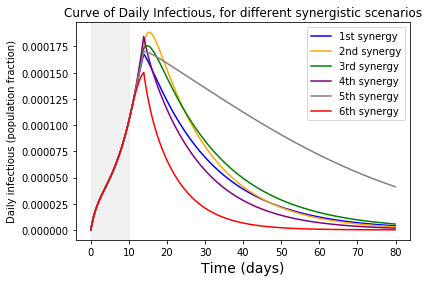

In [8]:
# plot infectious evolution

stop_plot_synergy = 800

f, ax = plt.subplots(nrows=1, ncols=1)

plot(t[:stop_plot_synergy],results_synergy1.T[2,:stop_plot_synergy],"blue",label="1st synergy")
plot(t[:stop_plot_synergy],results_synergy2.T[2,:stop_plot_synergy],"orange",label="2nd synergy")
plot(t[:stop_plot_synergy],results_synergy3.T[2,:stop_plot_synergy],"green",label="3rd synergy")
plot(t[:stop_plot_synergy],results_synergy4.T[2,:stop_plot_synergy],"purple",label="4th synergy")
plot(t[:stop_plot_synergy],results_synergy5.T[2,:stop_plot_synergy],"gray",label="5th synergy")
plot(t[:stop_plot_synergy],results_synergy6.T[2,:stop_plot_synergy],"red",label="6th synergy")
# NB: 4 and 6 are swapped to be consistent with text



plt.title("Curve of Daily Infectious, for different synergistic scenarios")
xlabel("Time (days)", fontsize=14)
plt.legend()
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Daily infectious (population fraction)")

f.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/synergies_daily.pdf",bbox_inches = "tight",transparent=True)


In [9]:
#plot(t[:1000],results_synergy1.T[4,:1000])

In [10]:
sum1 = cumsum(results_synergy1.T[2])*gamma*dt
sum2 = cumsum(results_synergy2.T[2])*gamma*dt
sum3 = cumsum(results_synergy3.T[2])*gamma*dt
sum4 = cumsum(results_synergy4.T[2])*gamma*dt
sum5 = cumsum(results_synergy5.T[2])*gamma*dt
sum6 = cumsum(results_synergy6.T[2])*gamma*dt

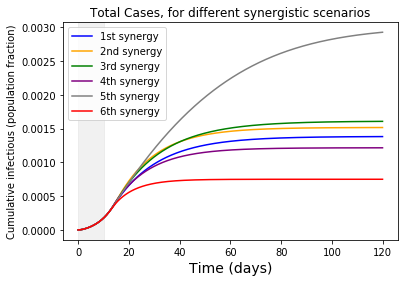

In [12]:
# plot infectious evolution

stop_plot_synergy = 1200

g, ax = plt.subplots(nrows=1, ncols=1)

plot(t[:stop_plot_synergy],sum1[:stop_plot_synergy],"blue",label="1st synergy")
plot(t[:stop_plot_synergy],sum2[:stop_plot_synergy],"orange",label="2nd synergy")
plot(t[:stop_plot_synergy],sum3[:stop_plot_synergy],"green",label="3rd synergy")
plot(t[:stop_plot_synergy],sum4[:stop_plot_synergy],"purple",label="4th synergy")
plot(t[:stop_plot_synergy],sum5[:stop_plot_synergy],"gray",label="5th synergy")
plot(t[:stop_plot_synergy],sum6[:stop_plot_synergy],"red",label="6th synergy")



plt.title("Total Cases, for different synergistic scenarios")
xlabel("Time (days)", fontsize=14)
plt.legend()
ax.axvspan(0, 10, alpha=0.3, color='lightgrey')

ylabel("Cumulative infectious (population fraction)")

g.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/synergies_cumulative.pdf",bbox_inches = "tight",transparent=True)


### Getting corresponding R

In [13]:
R = []

for i in range(6):
    R.append( beta*rho[i]*(1/(gamma+eta[i]))*((1-mu[i])**30)*((1-mu_ld[i])**4)*(alpha/(alpha+0.33*chi[i])) )
    
print (R)

#remember that 4th and 6th are swapped

[0.6474899092690716, 0.6651203460026209, 0.6368196404792061, 0.6499299095195615, 0.8355079095726625, 0.32440788427912887]


### Histogram for T

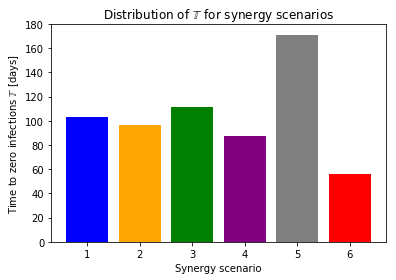

In [15]:
h = plt.figure()
plt.bar([1,2,3,4,5,6],zero_infectious_position_sy*0.1,color=["blue","orange","green","purple","grey","red"])
plt.title("Distribution of $\\mathbb{T} \,$ for synergy scenarios")
plt.xlabel("Synergy scenario")
plt.ylabel("Time to zero infections $\\mathbb{T} \,$ [days]")

h.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/AssessingSuppressionMeasures/plots_covid/synergies_time.pdf",bbox_inches = "tight",transparent=True)


# Compare with countries
Data from John Hopkins repository, https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series. Italian data from Protezionoe Civile repository, https://github.com/pcm-dpc/COVID-19 
Dates from 22 Jan to 08 July. 

Fit performed using lmfit package, model integration with odeint

In [16]:
from scipy.integrate import odeint
import scipy
from lmfit import minimize, Parameters, Parameter, report_fit

In [21]:
#using odeint

def residual(paras, t, data):

    """
    compute the residual between actual data and fitted data
    """

    x0 = paras['x10'].value, paras['x20'].value, paras['x30'].value, paras['x40'].value, paras['x50'].value, paras['x60'].value
    model = odeint(synergies_seir_model_1,x0, t, args=(paras,1))

    # you only have data for one of your variables
    x2_model = model[:,2]
    plot(x2_model)
    return (x2_model - data).ravel()


def synergies_seir_model_1(init_vals,t,paras,data): 

    S=init_vals[0]
    E=init_vals[1]
    I=init_vals[2]
    P=init_vals[3]
    Q=init_vals[4]
    R=init_vals[5]
    #modelparameter
    alpha = paras['alpha'].value
    beta = paras['beta'].value
    gamma = paras['gamma'].value
    rho = paras['rho'].value
    mu = paras['mu'].value
    chi = paras['chi'].value
    eta = paras['eta'].value
    tau = paras['tau'].value

    if (t<tau): 
        rho0=1
        mu0=0
        chi0=0
        eta0=0
    if ((t>=tau) and (t<tau+7)):
        mu0=mu
        chi0=0
        eta0=0
        rho0=1
    if (t>=tau+7):
        rho0= rho
        chi0 = chi
        eta0= eta
        mu0= mu      
    dydt=[-rho0*beta*S*I-mu0*S,#S
         rho0*beta*S*I - alpha*E - chi0*0.33*E,#E
         alpha*E - gamma*I - eta*I,#I
         mu0*S,#P
         chi0*0.33*E + eta*I,#Q
         gamma*I]#R
    return dydt   


# for the plot
def synergies_seir_model(init_vals,t,paras,data): 

    S=init_vals[0]
    E=init_vals[1]
    I=init_vals[2]
    P=init_vals[3]
    Q=init_vals[4]
    R=init_vals[5]
    #modelparameter
    alpha = paras[0]
    beta = paras[1]
    gamma = paras[2]
    rho = paras[3]
    mu = paras[4]
    chi = paras[5]
    eta = paras[6]
    tau = paras[7]

    if (t<tau): 
        rho0=1
        mu0=0
        chi0=0
        eta0=0
    if ((t>=tau) and (t<tau+7)):
        mu0=mu
        chi0=0
        rho0=1
        eta0=0
    if (t>=tau+7):
        rho0=rho
        chi0 = chi
        eta0 = eta
        mu0=0       
    dydt=[-rho0*beta*S*I-mu0*S,#S
         rho0*beta*S*I - alpha*E - chi0*0.33*E,#E
         alpha*E - gamma*I - eta*I,#I
         mu0*S,#P
         chi0*0.33*E + eta*I,#Q
         gamma*I]#R
    return dydt   


NB: before starting the fitting, run the corresponding cells above to set the correct initial conditions

## Austria

Parameters([('x10', <Parameter 'x10', value=0.9999998888888889 (fixed), bounds=[-inf:inf]>), ('x20', <Parameter 'x20', value=1.1111111111111111e-07 (fixed), bounds=[-inf:inf]>), ('x30', <Parameter 'x30', value=0 (fixed), bounds=[-inf:inf]>), ('x40', <Parameter 'x40', value=0 (fixed), bounds=[-inf:inf]>), ('x50', <Parameter 'x50', value=0 (fixed), bounds=[-inf:inf]>), ('x60', <Parameter 'x60', value=0 (fixed), bounds=[-inf:inf]>), ('rho', <Parameter 'rho', value=0.2627900473077239 +/- 0.158, bounds=[0.01:0.7]>), ('mu', <Parameter 'mu', value=0.001039993011892157 +/- 0.000874, bounds=[0.001:0.4]>), ('chi', <Parameter 'chi', value=0.0013805540577402574 +/- 0.275, bounds=[0.001:0.7]>), ('alpha', <Parameter 'alpha', value=0.2 (fixed), bounds=[-inf:inf]>), ('beta', <Parameter 'beta', value=0.85 (fixed), bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.34 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=64 (fixed), bounds=[-inf:inf]>), ('eta', <Parameter 'eta', value=0.

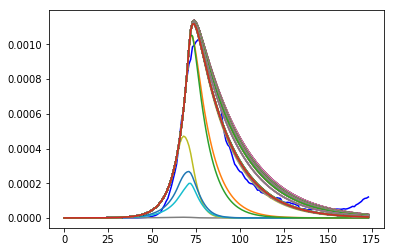

In [112]:

# initial conditions
AT_N = 9000000
AT_init_vals = 1 - 1/AT_N, 1/AT_N, 0, 0, 0 ,0    #working with fractions of population

AT_active = numpy.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,3,9,14,18,21,29,41,55,79,104,129,178,242,297,497,648,853,1009,1328,1633,1998,2373,2797,3557,4444,5246,5549,6748,7374,7978,8223,8874,8957,9129,9222,9334,9088,8849,8614,8350,8157,7709,7172,6865,6608,6330,6209,5845,5080,4460,4014,3796,3694,3411,3087,2786,2669,2509,2401,2363,2208,2043,1961,1832,1782,1771,1705,1582,1437,1445,1324,1290,1262,1201,1190,1069,1027,1010,1048,1050,1026,1011,838,820,796,810,800,760,732,718,674,640,497,470,469,461,429,418,429,437,437,457,432,422,411,404,389,373,391,419,417,434,442,460,454,449,454,474,459,476,509,551,600,583,677,722,787,853,959,1012,1029,1086])/AT_N
time = np.linspace(0,len(AT_active)-1,len(AT_active))

x10 = AT_init_vals[0]
x20 = AT_init_vals[1]
x30 = AT_init_vals[2]
x40 = AT_init_vals[3]
x50 = AT_init_vals[4]
x60 = AT_init_vals[5]
y0 = [x10, x20, x30, x40, x50, x60]

# measured data
t_measured = time
x2_measured = AT_active

#plt.figure()
plt.plot(t_measured, x2_measured, color='b', label='measured data')

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('x10', value=x10, vary=False)
params.add('x20', value=x20, vary=False)
params.add('x30', value=x30, vary=False)
params.add('x40', value=x40, vary=False)
params.add('x50', value=x40, vary=False)
params.add('x60', value=x40, vary=False)
params.add('rho', value=0.3, min=0.01, max=0.7)
params.add('mu', value=0, min=0.001, max=0.4) # vary=False) #   
params.add('chi', value=0, min=0.001,max=0.7)  #   vary=False) #  
params.add('alpha', value=alpha, vary=False)
params.add('beta', value=beta, vary=False)
params.add('gamma', value=gamma, vary=False)
params.add('tau', value=64, vary=False)
params.add('eta', value=0., min=0.001,max=0.3)  # vary=False) #

# fit model
result = minimize(residual, params, args=(t_measured, x2_measured), method='leastsq')  # leastsq nelder
# check results of the fit
print(result.params)

report_fit(result)


0.6249999999999999
0.6297410559786409


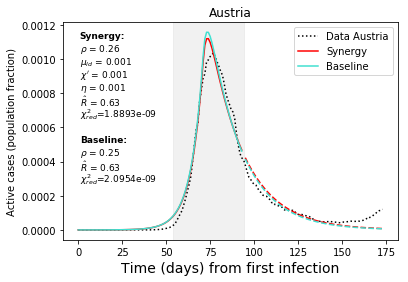

In [113]:
AT_N = 9000000
AT_init_vals = 1 - 1/AT_N, 1/AT_N, 0, 0, 0 ,0    #working with fractions of population
AT_mu =    [0.0,0.001]       # removal rate
AT_rho =   [0.25,0.26]   # social distancing tuning
AT_chi =   [0.0,0.001]   # latents' removal (e.g. contact tracing)
AT_eta =   [0.0,0.001]   # contagious' removal

AT_params_soc_dist = alpha, beta, gamma,  AT_rho[0], AT_mu[0], AT_chi[0], AT_eta[0], 64  # parameters, including time from first (simulated) case to lockdown (that is an extra parameter)
AT_results_soc_dist = odeint(synergies_seir_model, y0, time, args=(AT_params_soc_dist,1))

AT_params_synergy = alpha, beta, gamma,  AT_rho[1], AT_mu[1], AT_chi[1], AT_eta[1], 64  # parameters, including time from first (simulated) case to lockdown (that is an extra parameter)
AT_results_synergy = odeint(synergies_seir_model, y0, time, args=(AT_params_synergy,1))

AT, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(time,AT_active,':',color="black",label="Data Austria")
plot(time[:94],AT_results_synergy[:94,2],"red",label="Synergy")
plot(time[95:],AT_results_synergy[95:,2],'--',color="red")

plot(time[:94],AT_results_soc_dist[:94,2],"turquoise",label="Baseline")
plot(time[95:],AT_results_soc_dist[95:,2],'--',color="turquoise")


plt.legend()
plt.xlabel("Time (days) from first infection",fontsize=14)
plt.ylabel("Active cases (population fraction)")
title("Austria")
ax.axvspan(54, 94, alpha=0.3, color='lightgrey')
text(0.05, 0.94, 'Synergy:', horizontalalignment='left',verticalalignment='center',weight='bold', transform=ax.transAxes,fontsize =9)
text(0.05, 0.88, '$\\rho$ = 0.26', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.82, '$\\mu_{ld}$ = 0.001', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.76, "$\\chi'$ = 0.001", horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.70, "$\\eta$ = 0.001", horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.64, '$\\hat{R}$ = 0.63', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.58, '$\\chi^2_{red}$=1.8893e-09', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)

text(0.05, 0.46, 'Baseline:', horizontalalignment='left',verticalalignment='center',weight='bold', transform=ax.transAxes,fontsize =9)
text(0.05, 0.40, '$\\rho$ = 0.25', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.34, '$\\hat{R}$ = 0.63', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.28, '$\\chi^2_{red}$=2.0954e-09', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)

AT.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/assessingSuppressionMeasures/plots_covid/austria.pdf",bbox_inches = "tight",transparent=True)


# Corresponding R

R_soc_dist = AT_rho[0]*beta/gamma
R_synergy = beta/(gamma+eta[1])*AT_rho[1]*((1-AT_mu[1])**30)*(alpha/(alpha+0.33*AT_chi[1])) 

print(R_soc_dist)
print(R_synergy)


## Denmark

Parameters([('x10', <Parameter 'x10', value=0.9999998333333333 (fixed), bounds=[-inf:inf]>), ('x20', <Parameter 'x20', value=1.6666666666666668e-07 (fixed), bounds=[-inf:inf]>), ('x30', <Parameter 'x30', value=0 (fixed), bounds=[-inf:inf]>), ('x40', <Parameter 'x40', value=0 (fixed), bounds=[-inf:inf]>), ('x50', <Parameter 'x50', value=0 (fixed), bounds=[-inf:inf]>), ('x60', <Parameter 'x60', value=0 (fixed), bounds=[-inf:inf]>), ('rho', <Parameter 'rho', value=0.32143120366815825 +/- 0.00634, bounds=[0.01:0.7]>), ('mu', <Parameter 'mu', value=0.0011401218525006745 +/- 6.66e-05, bounds=[0.001:0.4]>), ('chi', <Parameter 'chi', value=0 (fixed), bounds=[-inf:inf]>), ('alpha', <Parameter 'alpha', value=0.2 (fixed), bounds=[-inf:inf]>), ('beta', <Parameter 'beta', value=0.85 (fixed), bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.34 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=59 (fixed), bounds=[-inf:inf]>), ('eta', <Parameter 'eta', value=0.0012827778438565048

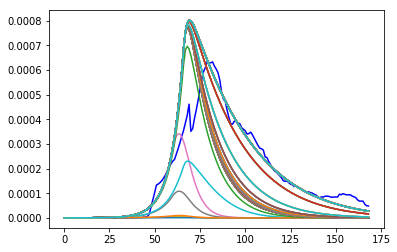

In [110]:

# initial conditions
DK_N = 6000000
DK_init_vals = 1 - 1/DK_N, 1/DK_N, 0, 0, 0 ,0    #working with fractions of population

DK_active = numpy.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,3,4,4,6,10,10,22,22,34,89,261,441,614,800,825,861,910,972,1052,1144,1245,1312,1381,1425,1558,1689,1835,1993,2135,2322,2499,2769,2109,2174,2425,2633,2863,3116,3377,3563,3662,3799,3781,3778,3798,3697,3624,3535,3348,3049,2888,2839,2625,2441,2295,2281,2358,2348,2312,2296,2199,2160,2122,2043,2052,2089,2022,1939,1858,1769,1700,1683,1652,1484,1471,1371,1295,1208,1153,1119,1077,1027,978,905,892,898,860,821,809,764,785,735,733,711,665,639,609,636,616,604,577,559,519,487,512,507,528,529,527,511,502,509,509,509,578,565,590,573,563,563,563,534,514,495,440,409,409,409,336,296,290])/DK_N
time = np.linspace(0,len(DK_active)-1,len(DK_active))

x10 = DK_init_vals[0]
x20 = DK_init_vals[1]
x30 = DK_init_vals[2]
x40 = DK_init_vals[3]
x50 = DK_init_vals[4]
x60 = DK_init_vals[5]
y0 = [x10, x20, x30, x40, x50, x60]

# measured data
t_measured = time
x2_measured = DK_active

#plt.figure()
plt.plot(t_measured, x2_measured, color='b', label='measured data')

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('x10', value=x10, vary=False)
params.add('x20', value=x20, vary=False)
params.add('x30', value=x30, vary=False)
params.add('x40', value=x40, vary=False)
params.add('x50', value=x40, vary=False)
params.add('x60', value=x40, vary=False)
params.add('rho', value=0.2, min=0.01, max=0.7)
params.add('mu', value=0,  min=0.001, max=0.4) #vary=False) # 
params.add('chi', value=0,  vary=False) #  min=0.001,max=0.7)  # 
params.add('alpha', value=alpha, vary=False)
params.add('beta', value=beta, vary=False)
params.add('gamma', value=gamma, vary=False)
params.add('tau', value=59, vary=False)
params.add('eta', value=0, min=0.001,max=0.3)  # vary=False) #

# fit model
result = minimize(residual, params, args=(t_measured, x2_measured), method='leastsq')  # leastsq nelder
# check results of the fit
print(result.params)

report_fit(result)


0.7763447738104684
0.7649999999999999


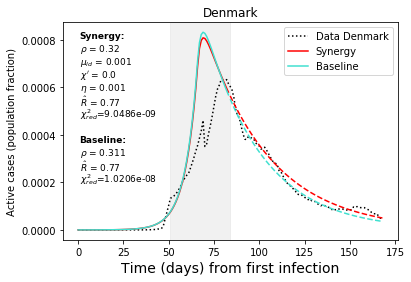

In [111]:
DK_N = 6000000
DK_init_vals = 1 - 1/DK_N, 1/DK_N, 0, 0, 0 ,0    #working with fractions of population
DK_mu =    [0.0,0.001]       # removal rate
DK_rho =   [0.306,0.32]   # social distancing tuning
DK_chi =   [0.0,0.0]   # latents' removal (e.g. contact tracing)
DK_eta =   [0.0,0.001]   # latents' removal (e.g. contact tracing)

DK_params_soc_dist = alpha, beta, gamma,  DK_rho[0], DK_mu[0], DK_chi[0], DK_eta[0], 59  # parameters, including time from first (simulated) case to lockdown (that is an extra parameter)
DK_results_soc_dist = odeint(synergies_seir_model, y0, time, args=(DK_params_soc_dist,1))

DK_params_synergy = alpha, beta, gamma,  DK_rho[1], DK_mu[1], DK_chi[1], DK_eta[1], 59  # parameters, including time from first (simulated) case to lockdown (that is an extra parameter)
DK_results_synergy = odeint(synergies_seir_model, y0, time, args=(DK_params_synergy,1))

DK, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(time,DK_active,':',color="black",label="Data Denmark")
plot(time[:84],DK_results_synergy[:84,2],"red",label="Synergy")
plot(time[84:],DK_results_synergy[84:,2],'--',color="red")

plot(time[:84],DK_results_soc_dist[:84,2],"turquoise",label="Baseline")
plot(time[84:],DK_results_soc_dist[84:,2],'--',color="turquoise")


plt.legend()
plt.xlabel("Time (days) from first infection",fontsize=14)
plt.ylabel("Active cases (population fraction)")
title("Denmark")
ax.axvspan(51, 84, alpha=0.3, color='lightgrey')
text(0.05, 0.94, 'Synergy:', horizontalalignment='left',verticalalignment='center',weight='bold', transform=ax.transAxes,fontsize =9)
text(0.05, 0.88, '$\\rho$ = 0.32', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.82, '$\\mu_{ld}$ = 0.001', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.76, "$\\chi'$ = 0.0", horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.70, "$\\eta$ = 0.001", horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.64, '$\\hat{R}$ = 0.77', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.58, '$\\chi^2_{red}$=9.0486e-09', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)

text(0.05, 0.46, 'Baseline:', horizontalalignment='left',verticalalignment='center',weight='bold', transform=ax.transAxes,fontsize =9)
text(0.05, 0.40, '$\\rho$ = 0.311', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.34, '$\\hat{R}$ = 0.77', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.28, '$\\chi^2_{red}$=1.0206e-08', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)

DK.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/assessingSuppressionMeasures/plots_covid/denmark.pdf",bbox_inches = "tight",transparent=True)


# Corresponding R

R_soc_dist = DK_rho[0]*beta/gamma
R_synergy = beta/(gamma+eta[1])*DK_rho[1]*((1-DK_mu[1])**30)*(alpha/(alpha+0.33*DK_chi[1])) 


print(R_synergy)
print(R_soc_dist)

## Ireland

Parameters([('x10', <Parameter 'x10', value=0.9999998 (fixed), bounds=[-inf:inf]>), ('x20', <Parameter 'x20', value=2e-07 (fixed), bounds=[-inf:inf]>), ('x30', <Parameter 'x30', value=0 (fixed), bounds=[-inf:inf]>), ('x40', <Parameter 'x40', value=0 (fixed), bounds=[-inf:inf]>), ('x50', <Parameter 'x50', value=0 (fixed), bounds=[-inf:inf]>), ('x60', <Parameter 'x60', value=0 (fixed), bounds=[-inf:inf]>), ('rho', <Parameter 'rho', value=0.21217791002118577 +/- 0.0103, bounds=[0.01:0.7]>), ('mu', <Parameter 'mu', value=0.00108107668480476 +/- 6.66e-05, bounds=[0.001:0.4]>), ('chi', <Parameter 'chi', value=0 (fixed), bounds=[-inf:inf]>), ('alpha', <Parameter 'alpha', value=0.2 (fixed), bounds=[-inf:inf]>), ('beta', <Parameter 'beta', value=0.85 (fixed), bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.34 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=68 (fixed), bounds=[-inf:inf]>), ('eta', <Parameter 'eta', value=0.0020411379518609826 +/- 0.00141, bounds=[0.001:0

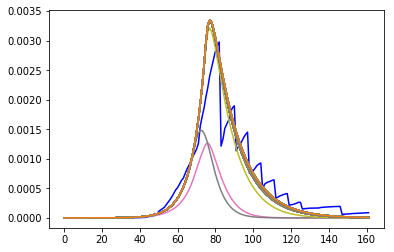

In [108]:

# initial conditions
IR_N = 5000000
IR_init_vals = 1 - 1/IR_N, 1/IR_N, 0, 0, 0 ,0    #working with fractions of population

#less 7 zeros -> 29/01
IR_active = numpy.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,6,6,18,18,19,21,34,42,42,89,127,127,167,216,285,549,675,777,897,1114,1317,1550,1795,2094,2374,2564,2851,3159,3357,3746,4148,4442,4811,5165,5474,5814,6286,7777,8583,9296,10257,11048,12026,12708,13373,14110,14564,14888,6077,6669,7580,7937,8265,8942,9313,9485,5677,5994,6182,6504,6817,7067,7258,3763,3872,4002,4204,4428,4558,4644,2434,2851,2968,3045,3099,3183,3220,1684,1748,1854,1918,1971,2032,2060,1083,1113,1142,1189,1249,1323,1319,754,780,795,807,824,826,826,838,837,847,892,899,917,927,933,943,956,961,966,968,973,306,314,320,339,340,363,373,375,387,394,404,422,426,432,440])/IR_N
time = np.linspace(0,len(IR_active)-1,len(IR_active))

x10 = IR_init_vals[0]
x20 = IR_init_vals[1]
x30 = IR_init_vals[2]
x40 = IR_init_vals[3]
x50 = IR_init_vals[4]
x60 = IR_init_vals[5]
y0 = [x10, x20, x30, x40, x50, x60]

# measured data
t_measured = time
x2_measured = IR_active

#plt.figure()
plt.plot(t_measured, x2_measured, color='b', label='measured data')

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('x10', value=x10, vary=False)
params.add('x20', value=x20, vary=False)
params.add('x30', value=x30, vary=False)
params.add('x40', value=x40, vary=False)
params.add('x50', value=x40, vary=False)
params.add('x60', value=x40, vary=False)
params.add('rho', value=0.2, min=0.01, max=0.7)
params.add('mu', value=0,   min=0.001, max=0.4) # vary=False) # 
params.add('chi', value=0,   vary=False) # min=0.001,max=0.7)  # 
params.add('alpha', value=alpha, vary=False)
params.add('beta', value=beta, vary=False)
params.add('gamma', value=gamma, vary=False)
params.add('tau', value=68, vary=False) 
params.add('eta', value=0.002, min=0.001,max=0.3)  # vary=False) #

# fit model
result = minimize(residual, params, args=(t_measured, x2_measured), method='leastsq')  # leastsq nelder
# check results of the fit
print(result.params)

report_fit(result)


0.5249999999999999
0.475


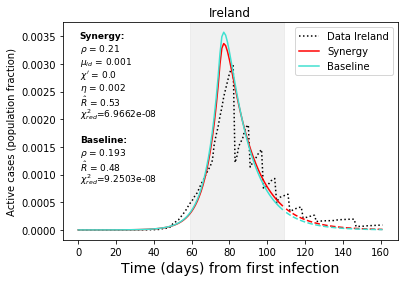

In [109]:
IR_N = 6000000
IR_init_vals = 1 - 1/IR_N, 1/IR_N, 0, 0, 0 ,0    #working with fractions of population
IR_mu =    [0.0,0.0]       # removal rate
IR_mu_ld = [0.0,0.001]   # removal rate for hard lockdown
IR_rho =   [0.19,0.21]   # social distancing tuning
IR_chi =   [0.0,0.0]   # latents' removal (e.g. contact tracing)
IR_eta =   [0.0,0.002]   # contagious' removal (e.g. contact tracing)

IR_params_soc_dist = alpha, beta, gamma,  IR_rho[0], IR_mu[0], IR_chi[0], IR_eta[0], 68  # parameters, including time from first (simulated) case to lockdown (that is an extra parameter)
IR_results_soc_dist = odeint(synergies_seir_model, y0, time, args=(IR_params_soc_dist,1))

IR_params_synergy = alpha, beta, gamma,  IR_rho[1], IR_mu[1], IR_chi[1], IR_eta[1], 68  # parameters, including time from first (simulated) case to lockdown (that is an extra parameter)
IR_results_synergy = odeint(synergies_seir_model, y0, time, args=(IR_params_synergy,1))

IR, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(time,IR_active,':',color="black",label="Data Ireland")
plot(time[:109],IR_results_synergy[:109,2],"red",label="Synergy")
plot(time[110:],IR_results_synergy[110:,2],'--',color="red")

plot(time[:109],IR_results_soc_dist[:109,2],"turquoise",label="Baseline")
plot(time[110:],IR_results_soc_dist[110:,2],'--',color="turquoise")


plt.legend()
plt.xlabel("Time (days) from first infection",fontsize=14)
plt.ylabel("Active cases (population fraction)")
title("Ireland")
ax.axvspan(59, 109, alpha=0.3, color='lightgrey')
text(0.05, 0.94, 'Synergy:', horizontalalignment='left',verticalalignment='center',weight='bold', transform=ax.transAxes,fontsize =9)
text(0.05, 0.88, '$\\rho$ = 0.21', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.82, '$\\mu_{ld}$ = 0.001', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.76, "$\\chi'$ = 0.0", horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.70, "$\\eta$ = 0.002", horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.64, '$\\hat{R}$ = 0.53', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.58, '$\\chi^2_{red}$=6.9662e-08', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)

text(0.05, 0.46, 'Baseline:', horizontalalignment='left',verticalalignment='center',weight='bold', transform=ax.transAxes,fontsize =9)
text(0.05, 0.40, '$\\rho$ = 0.193', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.34, '$\\hat{R}$ = 0.48', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.28, '$\\chi^2_{red}$=9.2503e-08', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)

IR.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/assessingSuppressionMeasures/plots_covid/ireland.pdf",bbox_inches = "tight",transparent=True)


# Corresponding R

R_soc_dist = IR_rho[0]*beta/gamma
R_synergy = beta/(gamma+eta[1])*IR_rho[1]*((1-IR_mu[1])**50)*(alpha/(alpha+0.33*IR_chi[1])) 


print(R_synergy)
print(R_soc_dist)

## Israel

Parameters([('x10', <Parameter 'x10', value=0.9999998888888889 (fixed), bounds=[-inf:inf]>), ('x20', <Parameter 'x20', value=1.1111111111111111e-07 (fixed), bounds=[-inf:inf]>), ('x30', <Parameter 'x30', value=0 (fixed), bounds=[-inf:inf]>), ('x40', <Parameter 'x40', value=0 (fixed), bounds=[-inf:inf]>), ('x50', <Parameter 'x50', value=0 (fixed), bounds=[-inf:inf]>), ('x60', <Parameter 'x60', value=0 (fixed), bounds=[-inf:inf]>), ('rho', <Parameter 'rho', value=0.30961099464193387 +/- 0.31, bounds=[0.01:0.7]>), ('mu', <Parameter 'mu', value=0.0012010750093221256 +/- 3.61e-07, bounds=[0.001:0.4]>), ('chi', <Parameter 'chi', value=0.0010000425125628362 +/- 0.489, bounds=[0.001:0.7]>), ('alpha', <Parameter 'alpha', value=0.2 (fixed), bounds=[-inf:inf]>), ('beta', <Parameter 'beta', value=0.85 (fixed), bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.34 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=66 (fixed), bounds=[-inf:inf]>), ('eta', <Parameter 'eta', value=0

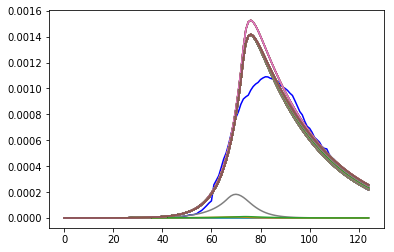

In [106]:

# initial conditions
IS_N = 9000000
IS_init_vals = 1 - 1/IS_N, 1/IS_N, 0, 0, 0 ,0    #working with fractions of population

#less 2 zeroes -> 24/01
IS_active = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,3,6,9,9,11,14,19,35,41,59,59,71,75,96,122,151,209,214,239,293,416,515,675,845,1033,1182,2306,2617,2944,3518,4100,4518,5114,5825,6483,6985,7380,7904,8262,8413,8530,8871,9130,9301,9415,9615,9728,9808,9798,9705,9645,9565,9487,9251,9094,9000,8861,8664,8511,8151,7772,7386,7163,6720,6363,6227,5947,5586,5434,5268,4962,4831,4795,4405,4186,4052,3793,3736,3485,3403,3114,2946,2884,2680,2496,2343,2285,2146,2019,1942,1909,1927,1917,1974,2006,2055,2103,2191,2245,2415,2474,2632,2722,2888,3019,3207,3315,3380,3520,3744,4021,4215,4449,4742,4778,5014,5335,5796,6084,5614,6102,6363,6904,7583,8483,9176,10060,11024,11677,12359,13653,14875])/IS_N
time = np.linspace(0,len(IS_active)-1,len(IS_active))

x10 = IS_init_vals[0]
x20 = IS_init_vals[1]
x30 = IS_init_vals[2]
x40 = IS_init_vals[3]
x50 = IS_init_vals[4]
x60 = IS_init_vals[5]
y0 = [x10, x20, x30, x40, x50, x60]

# measured data
t_measured = time[:125]
x2_measured = IS_active[:125]

#plt.figure()
plt.plot(t_measured, x2_measured, color='b', label='measured data')

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('x10', value=x10, vary=False)
params.add('x20', value=x20, vary=False)
params.add('x30', value=x30, vary=False)
params.add('x40', value=x40, vary=False)
params.add('x50', value=x40, vary=False)
params.add('x60', value=x40, vary=False)
params.add('rho', value=0.3, min=0.01, max=0.7)
params.add('mu', value=0,   min=0.001, max=0.4) # vary=False) # 
params.add('chi', value=0,  min=0.001,max=0.7)  #  vary=False) # 
params.add('alpha', value=alpha, vary=False)
params.add('beta', value=beta, vary=False)
params.add('gamma', value=gamma, vary=False)
params.add('tau', value=66, vary=False)   
params.add('eta', value=0, min=0.001,max=0.3)  # vary=False) #  

# fit model
result = minimize(residual, params, args=(t_measured, x2_measured), method='leastsq')  # leastsq nelder
# check results of the fit
print(result.params)

report_fit(result)

0.7737233564618379
0.7


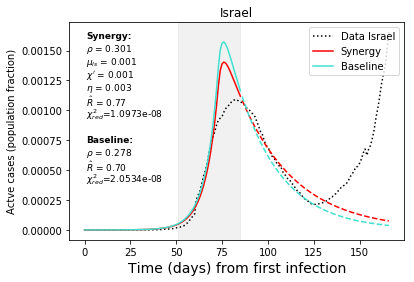

In [107]:
IS_init_vals = 1 - 1/IS_N, 1/IS_N, 0, 0, 0 ,0    #working with fractions of population
IS_mu =    [0.0,0.0]       # removal rate
IS_mu_ld = [0.0,0.001]   # removal rate for hard lockdown
IS_rho =   [0.28,0.31]   # social distancing tuning
IS_chi =   [0.0,0.001]   # latents' removal (e.g. contact tracing)
IS_eta =   [0.0,0.004]   # latents' removal (e.g. contact tracing)

IS_params_soc_dist = alpha, beta, gamma,  IS_rho[0], IS_mu[0], IS_chi[0], IS_eta[0], 66  # parameters, including time from first (simulated) case to lockdown (that is an extra parameter)
IS_results_soc_dist = odeint(synergies_seir_model, y0, time, args=(IS_params_soc_dist,1))

IS_params_synergy = alpha, beta, gamma,  IS_rho[1], IS_mu[1], IS_chi[1], IS_eta[1], 66  # parameters, including time from first (simulated) case to lockdown (that is an extra parameter)
IS_results_synergy = odeint(synergies_seir_model, y0, time, args=(IS_params_synergy,1))

IS, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(time,IS_active,':',color="black",label="Data Israel")
plot(time[:86],IS_results_synergy[:86,2],"red",label="Synergy")
plot(time[86:],IS_results_synergy[86:,2],'--',color="red")

plot(time[:86],IS_results_soc_dist[:86,2],"turquoise",label="Baseline")
plot(time[86:],IS_results_soc_dist[86:,2],'--',color="turquoise")


plt.legend(loc='upper right')
plt.xlabel("Time (days) from first infection",fontsize=14)
plt.ylabel("Actve cases (population fraction)")
title("Israel")
ax.axvspan(51, 85, alpha=0.3, color='lightgrey')
text(0.05, 0.94, 'Synergy:', horizontalalignment='left',verticalalignment='center',weight='bold', transform=ax.transAxes,fontsize =9)
text(0.05, 0.88, '$\\rho$ = 0.301', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.82, '$\\mu_{ls}$ = 0.001', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.76, "$\\chi'$ = 0.001", horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.70, '$\\eta$ = 0.003', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.64, '$\\hat{R}$ = 0.77', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.58, '$\\chi^2_{red}$=1.0973e-08', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)

text(0.05, 0.46, 'Baseline:', horizontalalignment='left',verticalalignment='center',weight='bold', transform=ax.transAxes,fontsize =9)
text(0.05, 0.40, '$\\rho$ = 0.278', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.34, '$\\hat{R}$ = 0.70', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.28, '$\\chi^2_{red}$=2.0534e-08', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)

IS.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/assessingSuppressionMeasures/plots_covid/israel.pdf",bbox_inches = "tight",transparent=True)


# Corresponding R

R_soc_dist = IS_rho[0]*beta/gamma
R_synergy = beta/(gamma+eta[1])*IS_rho[1]*((1-IS_mu[1])**34)*(alpha/(alpha+0.33*IS_chi[1])) 


print(R_synergy)
print(R_soc_dist)

## Lombardy

Parameters([('x10', <Parameter 'x10', value=0.9999999 (fixed), bounds=[-inf:inf]>), ('x20', <Parameter 'x20', value=1e-07 (fixed), bounds=[-inf:inf]>), ('x30', <Parameter 'x30', value=0 (fixed), bounds=[-inf:inf]>), ('x40', <Parameter 'x40', value=0 (fixed), bounds=[-inf:inf]>), ('x50', <Parameter 'x50', value=0 (fixed), bounds=[-inf:inf]>), ('x60', <Parameter 'x60', value=0 (fixed), bounds=[-inf:inf]>), ('rho', <Parameter 'rho', value=0.3937590207558742 +/- 0.00763, bounds=[0.01:0.4]>), ('mu', <Parameter 'mu', value=0.0010006684887342834 +/- 0.000307, bounds=[0.001:0.4]>), ('chi', <Parameter 'chi', value=0 (fixed), bounds=[-inf:inf]>), ('alpha', <Parameter 'alpha', value=0.2 (fixed), bounds=[-inf:inf]>), ('beta', <Parameter 'beta', value=0.85 (fixed), bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.34 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=74 (fixed), bounds=[-inf:inf]>), ('eta', <Parameter 'eta', value=0.001000317031457601 +/- 0.00232, bounds=[0.001:

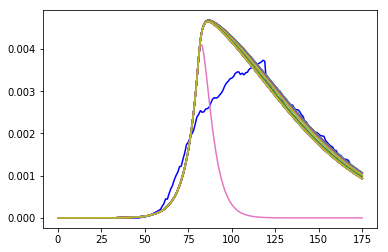

In [104]:
# initial conditions
LO_N = 10000000
LO_init_vals = 1 - 1/LO_N, 1/LO_N, 0, 0, 0 ,0    #working with fractions of population

#reports from 24/02/2020 to 30/06, data start at 05/01
LO_active= np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,166,231,249,349,474,552,887,1077,1326,1497,1777,2008,2742,3372,4490,4427,5763,6896,7732,9059,10043,10861,12095,12266,13938,15420,17370,17885,18910,19868,20591,22189,23895,24509,25392,25006,25124,25765,25876,26189,27220,28124,28469,28343,28545,29074,29530,30258,31265,31935,32363,32921,33090,33434,34195,34497,34587,33978,34242,33873,34368,34473,35166,35441,35744,36122,36211,36473,36667,36926,37307,37092,31753,32015,31983,30262,30190,30411,30675,30032,29956,27746,27679,27430,27073,27291,26671,26715,25933,25630,25614,25215,24477,24037,22913,22683,21809,20996,20861,20255,20224,20224,19853,19499,19420,19319,18297,17857,17340,17024,16785,15989,15976,15233,14972,14647,14045,13911,13843,13638,12903,12227,11992,11640,10992,10947,10823,10060])/10000000

time = np.linspace(0,len(LO_active)-1,len(LO_active))

x10 = LO_init_vals[0]
x20 = LO_init_vals[1]
x30 = LO_init_vals[2]
x40 = LO_init_vals[3]
x50 = LO_init_vals[4]
x60 = LO_init_vals[5]
y0 = [x10, x20, x30, x40, x50, x60]

# measured data
t_measured = time
x2_measured = LO_active

#plt.figure()
plt.plot(t_measured, x2_measured, color='b', label='measured data')

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('x10', value=x10, vary=False)
params.add('x20', value=x20, vary=False)
params.add('x30', value=x30, vary=False)
params.add('x40', value=x40, vary=False)
params.add('x50', value=x40, vary=False)
params.add('x60', value=x40, vary=False)
params.add('rho', value=0.5, min=0.01, max=0.4)
params.add('mu', value=0,  min=0.001, max=0.4) #   vary=False) # 
params.add('chi', value=0,  vary=False) #   min=0.001,max=0.7)  # 
params.add('alpha', value=alpha, vary=False)
params.add('beta', value=beta, vary=False)
params.add('gamma', value=gamma, vary=False)
params.add('tau', value=74, vary=False)   
params.add('eta', value=0, min=0.001,max=0.3)  # vary=False) # 

# fit model
result = minimize(residual, params, args=(t_measured, x2_measured), method='leastsq')  # leastsq nelder
# check results of the fit
print(result.params)

report_fit(result)

0.9681954409091045
0.94


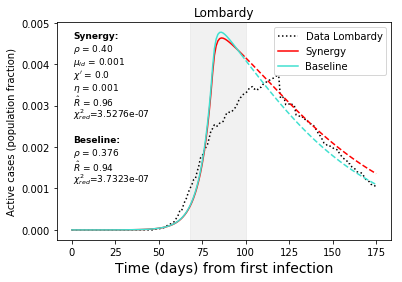

In [105]:
LO_init_vals = 1 - 1/LO_N, 1/LO_N, 0, 0, 0 ,0    #working with fractions of population
LO_mu =    [0.0,0.001]       # removal rate
LO_rho =   [0.376,0.39]   # social distancing tuning
LO_chi =   [0.0,0.0]   # latents' removal (e.g. contact tracing)
LO_eta =   [0.0,0.001]   # contagious' removal (e.g. contact tracing)

LO_params_soc_dist = alpha, beta, gamma,  LO_rho[0], LO_mu[0], LO_chi[0], LO_eta[0], 74  # parameters, including time from first (simulated) case to lockdown (that is an extra parameter)
LO_results_soc_dist = odeint(synergies_seir_model, y0, time, args=(LO_params_soc_dist,1))

LO_params_synergy = alpha, beta, gamma,  LO_rho[1], LO_mu[1], LO_chi[1], LO_eta[1], 74  # parameters, including time from first (simulated) case to lockdown (that is an extra parameter)
LO_results_synergy = odeint(synergies_seir_model, y0, time, args=(LO_params_synergy,1))

LO, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(time,LO_active,':',color="black",label="Data Lombardy")
plot(time[:100],LO_results_synergy[:100,2],"red",label="Synergy")
plot(time[100:],LO_results_synergy[100:,2],'--',color="red")

plot(time[:100],LO_results_soc_dist[:100,2],"turquoise",label="Baseline")
plot(time[100:],LO_results_soc_dist[100:,2],'--',color="turquoise")


plt.legend(loc='upper right')
plt.xlabel("Time (days) from first infection",fontsize=14)
plt.ylabel("Active cases (population fraction)")
title("Lombardy")
ax.axvspan(68, 100, alpha=0.3, color='lightgrey')
text(0.05, 0.94, 'Synergy:', horizontalalignment='left',verticalalignment='center',weight='bold', transform=ax.transAxes,fontsize =9)
text(0.05, 0.88, '$\\rho$ = 0.40', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.82, '$\\mu_{ld}$ = 0.001', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.76, "$\\chi'$ = 0.0", horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.70, "$\\eta$ = 0.001", horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.64, '$\\hat{R}$ = 0.96', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.58, '$\\chi^2_{red}$=3.5276e-07', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)

text(0.05, 0.46, 'Beseline:', horizontalalignment='left',verticalalignment='center',weight='bold', transform=ax.transAxes,fontsize =9)
text(0.05, 0.40, '$\\rho$ = 0.376', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.34, '$\\hat{R}$ = 0.94', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.28, '$\\chi^2_{red}$=3.7323e-07', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)

LO.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/assessingSuppressionMeasures/plots_covid/lombardy.pdf",bbox_inches = "tight",transparent=True)


# Corresponding R

R_soc_dist = LO_rho[0]*beta/gamma
R_synergy = beta/gamma*LO_rho[1]*((1-LO_mu[1])**7)*(alpha/(alpha+0.33*LO_chi[1])) 


print(R_synergy)
print(R_soc_dist)

## Switzerland

Parameters([('x10', <Parameter 'x10', value=0.9999998823529411 (fixed), bounds=[-inf:inf]>), ('x20', <Parameter 'x20', value=1.1764705882352942e-07 (fixed), bounds=[-inf:inf]>), ('x30', <Parameter 'x30', value=0 (fixed), bounds=[-inf:inf]>), ('x40', <Parameter 'x40', value=0 (fixed), bounds=[-inf:inf]>), ('x50', <Parameter 'x50', value=0 (fixed), bounds=[-inf:inf]>), ('x60', <Parameter 'x60', value=0 (fixed), bounds=[-inf:inf]>), ('rho', <Parameter 'rho', value=0.2865367695163522 +/- 0.00334, bounds=[0.01:0.4]>), ('mu', <Parameter 'mu', value=0.0016952332755452125 +/- 0.000125, bounds=[0.001:0.4]>), ('chi', <Parameter 'chi', value=0 (fixed), bounds=[-inf:inf]>), ('alpha', <Parameter 'alpha', value=0.2 (fixed), bounds=[-inf:inf]>), ('beta', <Parameter 'beta', value=0.85 (fixed), bounds=[-inf:inf]>), ('gamma', <Parameter 'gamma', value=0.34 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=67 (fixed), bounds=[-inf:inf]>), ('eta', <Parameter 'eta', value=0.0010002867868080375 

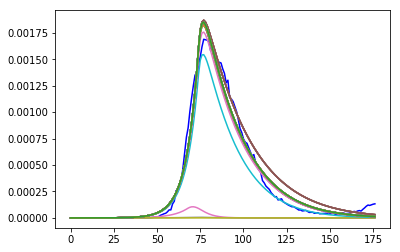

In [98]:
# initial conditions
CH_N = 8500000
CH_init_vals = 1 - 1/CH_N, 1/CH_N, 0, 0, 0 ,0    #working with fractions of population

#+ 8 zeroes -> 14/01
CH_active= np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,8,8,18,27,42,54,87,110,210,264,332,369,485,644,644,1124,1342,2182,2182,2669,2985,4019,5225,6485,7245,8544,9624,10613,11489,11167,12282,12934,13740,14349,14313,14278,14169,13424,13970,12836,12728,12585,12503,12449,11971,11609,10850,11062,9697,9551,9351,8936,8547,7915,7185,6859,6347,6088,5995,5651,5299,4965,5091,4449,4051,3855,3643,2997,2814,2555,2416,2284,2021,1872,1699,1713,1443,1491,1536,1293,1206,1111,1027,966,896,904,820,730,633,646,559,577,609,526,442,451,454,372,392,415,335,344,349,354,375,307,325,356,379,292,300,331,344,379,387,336,354,376,418,470,524,493,555,590,551,686,802,936,1033,1003,1050,1103,1132])/CH_N

time = np.linspace(0,len(CH_active)-1,len(CH_active))

x10 = CH_init_vals[0]
x20 = CH_init_vals[1]
x30 = CH_init_vals[2]
x40 = CH_init_vals[3]
x50 = CH_init_vals[4]
x60 = CH_init_vals[5]
y0 = [x10, x20, x30, x40, x50, x60]

# measured data
t_measured = time
x2_measured = CH_active

#plt.figure()
plt.plot(t_measured, x2_measured, color='b', label='measured data')

# set parameters including bounds; you can also fix parameters (use vary=False)
params = Parameters()
params.add('x10', value=x10, vary=False)
params.add('x20', value=x20, vary=False)
params.add('x30', value=x30, vary=False)
params.add('x40', value=x40, vary=False)
params.add('x50', value=x40, vary=False)
params.add('x60', value=x40, vary=False)
params.add('rho', value=0.3, min=0.01, max=0.4)
params.add('mu', value=0,  min=0.001, max=0.4) #  vary=False) # 
params.add('chi', value=0,  vary=False) #   min=0.001,max=0.7)  # 
params.add('alpha', value=alpha, vary=False)
params.add('beta', value=beta, vary=False)
params.add('gamma', value=gamma, vary=False)
params.add('tau', value=67, vary=False)   
params.add('eta', value=0, min=0.001,max=0.3)  # vary=False) # 

# fit model
result = minimize(residual, params, args=(t_measured, x2_measured), method='leastsq')  # leastsq nelder
# check results of the fit
print(result.params)

report_fit(result)

0.6718666083675532
0.695


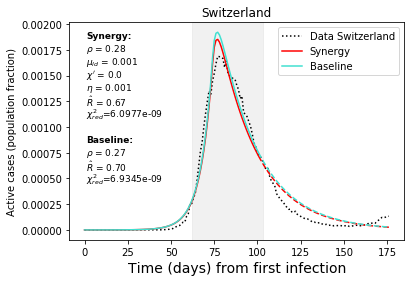

In [102]:
CH_init_vals = 1 - 1/CH_N, 1/CH_N, 0, 0, 0 ,0    #working with fractions of population
CH_mu =    [0.0,0.001]       # removal rate
CH_rho =   [0.278,0.28]   # social distancing tuning
CH_chi =   [0.0,0.0]   # latents' removal (e.g. contact tracing)
CH_eta =   [0.0,0.001]   # contagious' removal (e.g. contact tracing)

CH_params_soc_dist = alpha, beta, gamma,  CH_rho[0], CH_mu[0], CH_chi[0], CH_eta[0], 67  # parameters, including time from first (simulated) case to lockdown (that is an extra parameter)
CH_results_soc_dist = odeint(synergies_seir_model, y0, time, args=(CH_params_soc_dist,1))

CH_params_synergy = alpha, beta, gamma,  CH_rho[1], CH_mu[1], CH_chi[1], CH_eta[1], 67  # parameters, including time from first (simulated) case to lockdown (that is an extra parameter)
CH_results_synergy = odeint(synergies_seir_model, y0, time, args=(CH_params_synergy,1))

CH, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(time,CH_active,':',color="black",label="Data Switzerland")
plot(time[:103],CH_results_synergy[:103,2],"red",label="Synergy")
plot(time[103:],CH_results_synergy[103:,2],'--',color="red")

plot(time[:103],CH_results_soc_dist[:103,2],"turquoise",label="Baseline")
plot(time[103:],CH_results_soc_dist[103:,2],'--',color="turquoise")


plt.legend()
plt.xlabel("Time (days) from first infection",fontsize=14)
plt.ylabel("Active cases (population fraction)")
title("Switzerland")
ax.axvspan(62, 103, alpha=0.3, color='lightgrey')
text(0.05, 0.94, 'Synergy:', horizontalalignment='left',verticalalignment='center',weight='bold', transform=ax.transAxes,fontsize =9)
text(0.05, 0.88, '$\\rho$ = 0.28', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.82, '$\\mu_{ld}$ = 0.001', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.76, "$\\chi'$ = 0.0", horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.70, "$\\eta$ = 0.001", horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.64, '$\\hat{R}$ = 0.67', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.58, '$\\chi^2_{red}$=6.0977e-09', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)

text(0.05, 0.46, 'Baseline:', horizontalalignment='left',verticalalignment='center',weight='bold',  transform=ax.transAxes,fontsize =9)
text(0.05, 0.40, '$\\rho$ = 0.27', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.34, '$\\hat{R}$ = 0.70', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)
text(0.05, 0.28, '$\\chi^2_{red}$=6.9345e-09', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes,fontsize =9)

CH.savefig("/Users/daniele.proverbio/python-workspace/PhD/covid-19/assessingSuppressionMeasures/plots_covid/switzerland.pdf",bbox_inches = "tight",transparent=True)


# Corresponding R

R_soc_dist = CH_rho[0]*beta/gamma
R_synergy = beta/gamma*CH_rho[1]*((1-CH_mu[1])**41)*(alpha/(alpha+0.33*CH_chi[1])) 


print(R_synergy)
print(R_soc_dist)